# Rolling Planning mit Lateness (Tardiness + Earliness)

In [1]:
max_time = 60*2

In [2]:
import time

from ortools.sat.python import cp_model
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_rows', 20)


import utils.presenter as show
import utils.checker as check

import utils.scheduling_solver as ssv
import utils.rescheduling_solver_lateness as rssv

import utils.rolling_planning.init_jobs_times as rp_init
import utils.rolling_planning.procedure as rp_proced
import utils.schedule_deadline as deadline_gen

from ProductionDaySimulation import ProductionDaySimulation

In [3]:
start_notebook = time.time()

In [4]:
def get_schedule_filename(prefix: str = "", day: int = 0, data_txt: str = "schedule", suffix: str = "") -> str:
    file_template = "data/{prefix}_{data}_{day:02d}{suffix}.csv"
    if suffix:
        suffix = f"_{suffix}"
    return file_template.format(prefix=prefix,data=data_txt,day=day, suffix=suffix)

## Generierung des Datensatzes für 10 Tage (Ankunft)

In [5]:
df_instance = pd.read_csv("data/00_instance.csv")

df_jssp, df_arrivals = rp_init.init_jobs_with_arrivals(df_instance, 10,  u_b_mmax = 0.98)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
1895,Job_189,5,M9,76
1896,Job_189,6,M5,47
1897,Job_189,7,M3,52
1898,Job_189,8,M4,90


In [6]:
# Deadlines + Umwandlung in Integer
df_times = deadline_gen.get_times_df(df_jssp, df_arrivals, ssv.schedule_fcfs_with_arrivals, target_service=1)
df_times["Arrival"] = np.floor(df_times["Arrival"]).astype(int)
df_times["Deadline"] = np.ceil(df_times["Deadline"]).astype(int)
df_times

,Job,Arrival,Deadline
0,Job_000,0,1244
1,Job_001,80,1687
2,Job_002,140,1929
3,Job_003,191,2254
4,Job_004,226,1465
...,...,...,...
185,Job_185,14053,16117
186,Job_186,14059,15298
187,Job_187,14060,15850
188,Job_188,14176,15420


## Params

In [7]:
# fix
day_length = 1440
horizon_days = 3

In [8]:
# init
day_numb = 0

day_start = 0
day_end = 0
planning_end = 0

# Initialisierung (Tag 0)

In [9]:
day_numb = 0

day_start = day_length*day_numb                      # 0
day_end = day_start + day_length                     # 1440
planning_end =  day_start + horizon_days*day_length  # 4320

In [10]:
# I)
df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, planning_end)
df_jssp_curr

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
565,Job_056,5,M9,76
566,Job_056,6,M5,47
567,Job_056,7,M3,52
568,Job_056,8,M4,90


In [11]:
df_times_curr 

,Job,Arrival,Deadline
0,Job_000,0,1244
1,Job_001,80,1687
2,Job_002,140,1929
3,Job_003,191,2254
4,Job_004,226,1465
...,...,...,...
52,Job_052,3973,6037
53,Job_053,3979,5218
54,Job_054,3980,5770
55,Job_055,4096,5340


### Scheduling

In [12]:
starting_time = time.time()

# Scheduling
df_plan = ssv.solve_cp_jssp_lateness_by_tardiness_and_earliness(df_jssp_curr, df_times_curr,
                                                                w_t = 5,
                                                                msg=False, timeLimit=max_time, gapRel= 0.00)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan


Solver-Status         : OPTIMAL
Objective Value       : 105.00
Best Objective Bound  : 105.00
Laufzeit              : 0.85 Sekunden

Scheduling-Dauer: 0 Minuten und 0.87 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_000,0,0,1244,M0,0,29,29,-1215,0,1215
1,Job_000,1,0,1244,M1,29,78,107,-1137,0,1137
2,Job_001,0,80,1687,M0,80,43,123,-1564,0,1564
3,Job_000,2,0,1244,M2,107,9,116,-1128,0,1128
4,Job_000,3,0,1244,M3,116,36,152,-1092,0,1092
...,...,...,...,...,...,...,...,...,...,...,...
565,Job_051,9,3968,5531,M7,5506,25,5531,0,0,0
566,Job_049,9,3747,5628,M8,5554,74,5628,0,0,0
567,Job_054,9,3980,5770,M4,5737,33,5770,0,0,0
568,Job_056,9,4192,5894,M7,5849,45,5894,0,0,0


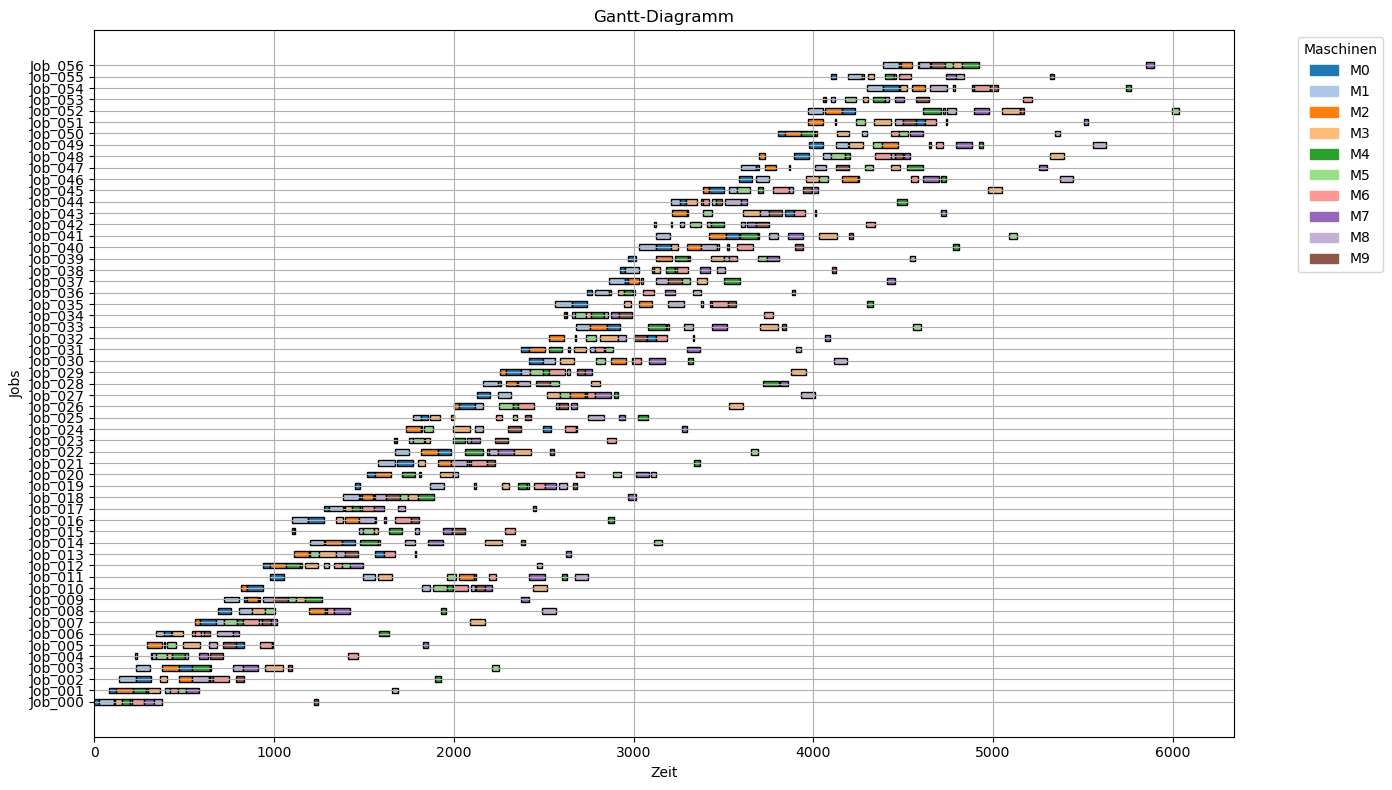

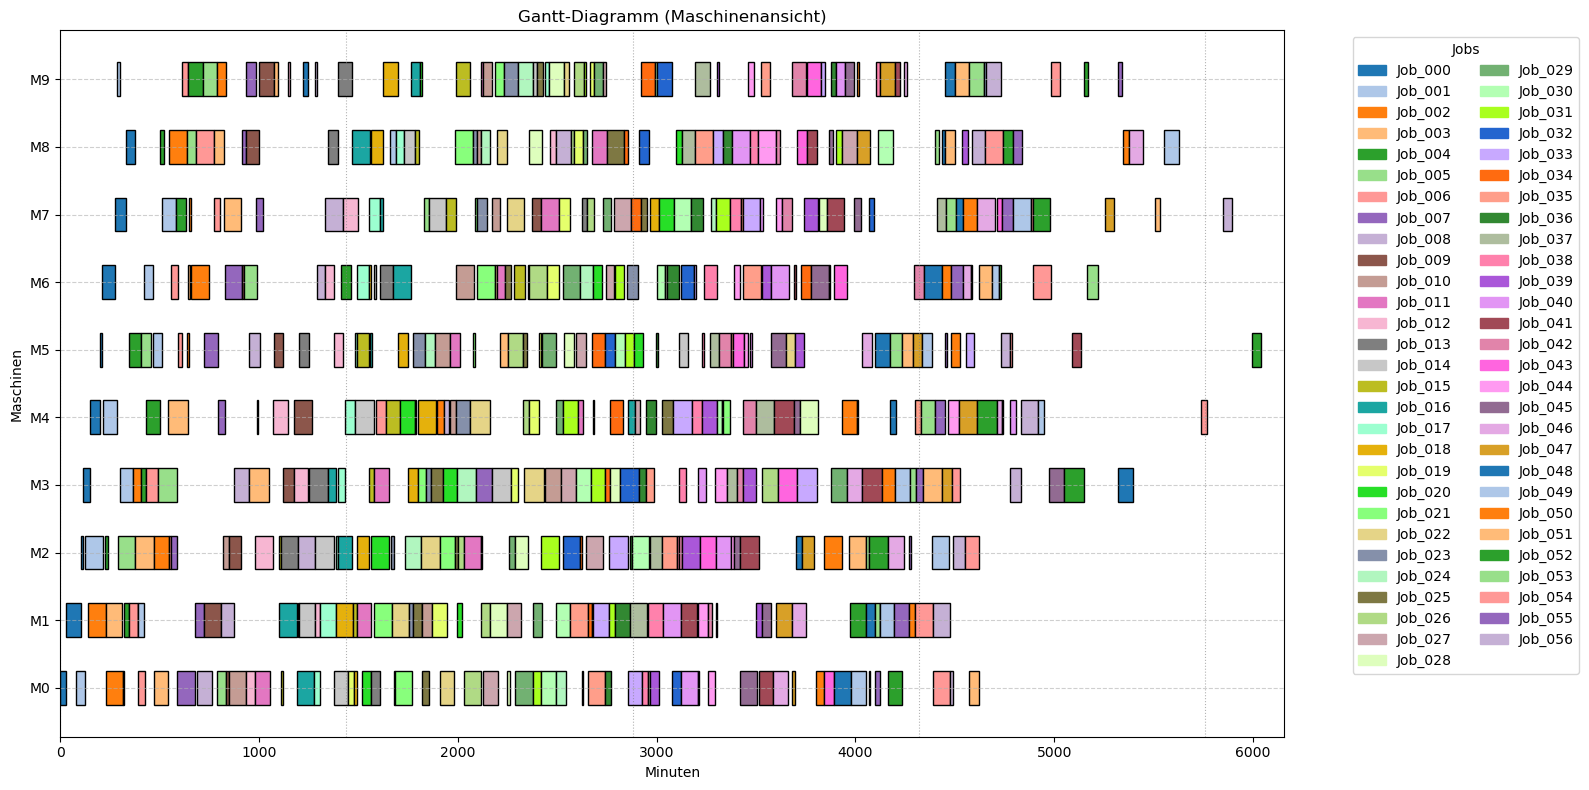

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [13]:
show.plot_gantt_jobs(df_plan)
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

In [14]:
last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Lateness", max_val = 90, steps= 30)

label
<-90          0
-90 - -60     0
-60 - -30     3
-30 - 0       0
0            54
0 - 30        0
30 - 60       0
60 - 90       0
>90           0
Name: count, dtype: int64

### Simulation

In [15]:
simulation = ProductionDaySimulation(df_plan, vc=0.35)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:13:11] Job_000 finished on M0 (after 13 minutes 12 seconds)
[00:29:00] Job_000 started on M1
[01:20:00] Job_001 started on M0
[01:55:19] Job_001 finished on M0 (after 35 minutes 20 seconds)
[02:03:00] Job_001 started on M2
[02:16:13] Job_000 finished on M1 (after 107 minutes 13 seconds)
[02:20:00] Job_002 started on M1
[03:57:14] Job_002 finished on M1 (after 97 minutes 14 seconds)
[03:57:14] Job_003 started on M1
[03:57:14] Job_002 started on M0
[04:16:52] Job_001 finished on M2 (after 133 minutes 52 seconds)
[04:16:52] Job_000 started on M2
[04:16:52] Job_001 started on M4
[04:24:41] Job_000 finished on M2 (after 07 minutes 49 seconds)
[04:24:41] Job_004 started on M2
[04:24:41] Job_000 started on M3
[04:43:51] Job_004 finished on M2 (after 19 minutes 10 seconds)
[04:52:25] Job_000 finished on M3 (after 27 minutes 44 seconds)
[04:53:00] Job_005 started on M2
[05:18:54] Job_001 finished on M4 (after 62 minutes 02 seconds)
[05:18:54] Job_000 started

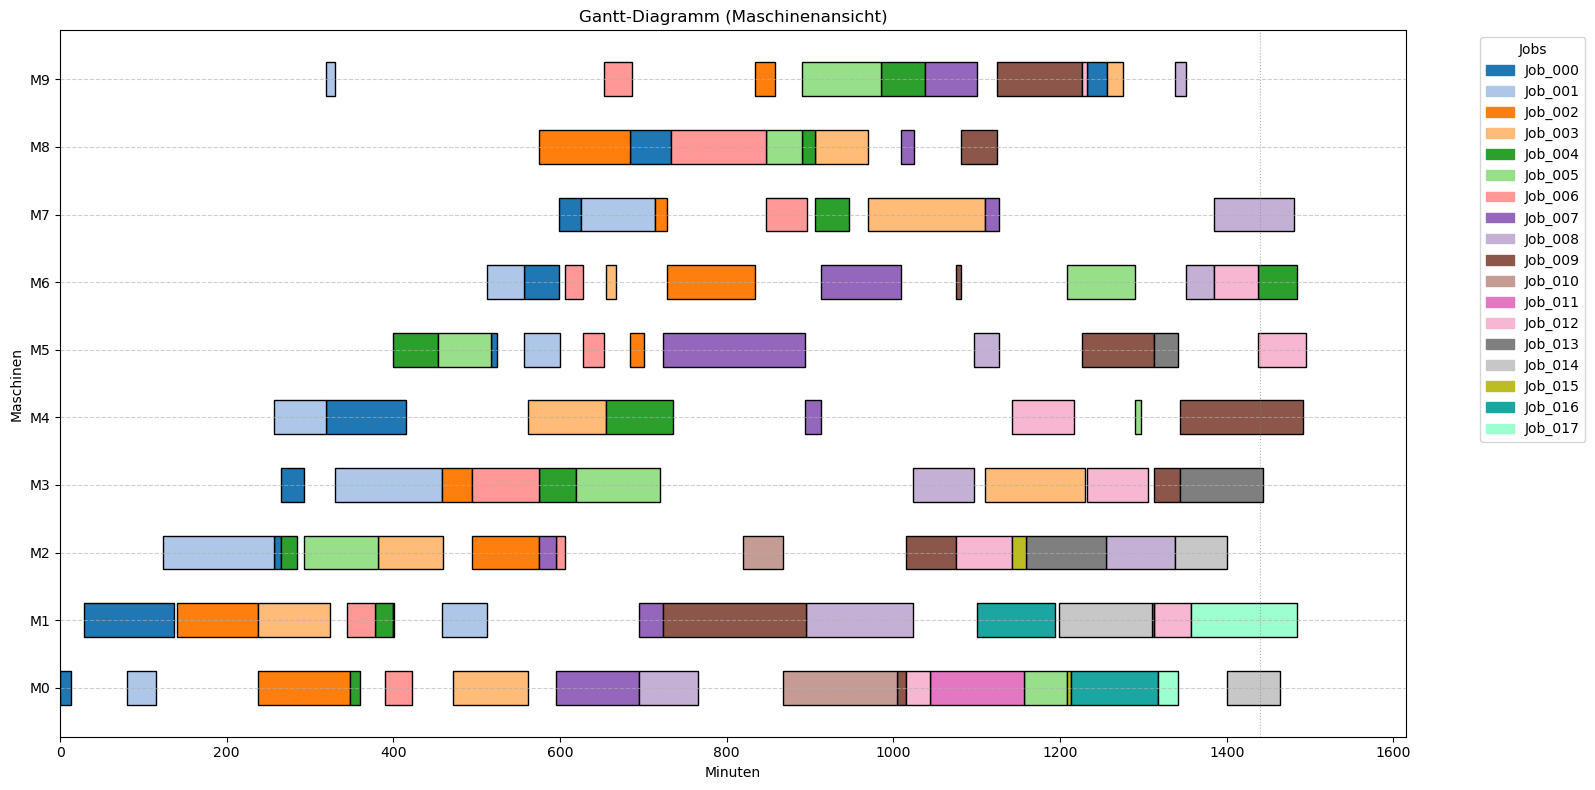

In [16]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

In [17]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_016,2,1100,M3,1346,39
1,Job_013,4,1088,M8,1347,48
2,Job_018,0,1312,M1,1386,85
3,Job_017,2,1216,M2,1387,9
4,Job_013,5,1088,M9,1395,72
...,...,...,...,...,...,...
450,Job_051,9,3968,M7,5506,25
451,Job_049,9,3747,M8,5554,74
452,Job_054,9,3980,M4,5737,33
453,Job_056,9,4192,M7,5849,45


In [18]:
df_plan.to_csv(get_schedule_filename("06", day=day_numb, suffix="init"), index = False)

In [19]:
df_plan_init = df_plan
df_execution_init = df_execution

In [20]:
-

SyntaxError: invalid syntax (476313318.py, line 1)

## A) Rolling Planning Simple

**Zielfunktion:**

Minimiere die gewichtete Summe aus Tardiness und Earliness der Jobs:

\\[
Z(\sigma) = \sum_{j} \left( w_t \cdot \text{Tardiness}_j + w_e \cdot \text{Earliness}_j \right)
\\]

wobei:

- \\( w_t \in \mathbb{N},\ w_e \in \mathbb{N} \\): Gewicht für Tardiness und Earliness  
- \\( \text{Tardiness}_j = \max(0, C_j - d_j) \\), \\( \text{Earliness}_j = \max(0, d_j - C_j) \\)  
    - \\( C_j \\): Fertigstellungszeitpunkt der letzten Operation von Job \\( j \\)  
    - \\( d_j \\): Deadline für Job \\( j \\)

In [ ]:
prefix_name = "06_simple"

first_start = 1
last_planning_start = 7

df_plan = df_plan_init
df_execution = df_execution_init

for day_numb in range(first_start, 2 + 1):
    day_start = day_length * day_numb
    day_end = day_start + day_length
    planning_end = day_start + horizon_days * day_length

    # ------------------- I. Ankunfts- und Operationsvorbereitung -------------------
    df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, planning_end)
    df_jssp_curr = rp_proced.extend_with_undone_operations(df_jssp_curr, df_undone)
    df_times_curr = rp_proced.update_times_after_operation_changes(df_times, df_jssp_curr)

    # ------------------- II. Relevante laufende Operationen -------------------------
    df_execution_important = rp_proced.get_operations_running_into_day(df_execution, day_start)

    # ------------------- III. Rescheduling durchführen -------------------------------

    starting_time = time.time()
    df_plan = rssv.solve_cp_jssp_lateness_by_tardiness_and_earliness_with_fixed_ops(df_jssp_curr, df_times_curr, df_execution_important,
                                                                                    w_t = 5, reschedule_start = day_start, 
                                                                                    msg=False, timeLimit=max_time, gapRel= 0)

    
    solver_duration = time.time() - starting_time
    print(f"\n  Scheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")

    df_plan.to_csv(get_schedule_filename(prefix_name, day=day_numb), index=False)

    show.plot_gantt_machines(df_plan, title=f"Gantt-Diagramm ab Tag {day_numb}")
    check.check_constraints(df_plan)

    last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
    print(show.count_column_grouped(last_ops, "Lateness", max_val = 180, steps= 60))

    # ------------------- IV. Einen Tag simulieren -------------------------------------

    simulation = ProductionDaySimulation(df_plan, vc=0.35)
    df_execution, df_undone = simulation.run(start_time=day_start, end_time=day_end)
    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}", duration_column="Simulated Processing Time")
    else:
        print(f"Nothing executed on day {day_numb}")

## B) Rolling Planning mit "Deviation Penalty"

**Zielfunktion:**

Minimiere die gewichtete Summe aus Tardiness, Earliness und Abweichung vom ursprünglichen Startzeitpunkt (Deviation):

\\[
Z(\sigma) = r \cdot \sum_{j} \left( w_t \cdot \text{Tardiness}_j + w_e \cdot \text{Earliness}_j \right) + (1 - r) \cdot \sum_{j,o} \left| S_{jo} - S_{jo}^{\text{original}} \right|
\\]

wobei:

- \\( r \in [0,\ 1] \\): Gewichtung zwischen Termintreue und Planstabilität  
- \\( w_t \in \mathbb{N},\ w_e \in \mathbb{N} \\): Gewicht für Tardiness und Earliness  
- \\( \text{Tardiness}_j = \max(0, C_j - d_j) \\), \\( \text{Earliness}_j = \max(0, d_j - C_j) \\)  
    - \\( C_j \\) ist das Fertigstellungsdatum des letzten Schritts von Job \\( j \\)  
    - \\( d_j \\) ist die Deadline für Job \\( j \\)  
- \\( S_{jo} \\) ist der Startzeitpunkt der \\( o \\)-ten Operation von Job \\( j \\)  
- \\( S_{jo}^{\text{original}} \\) ist der ursprünglich geplante Startzeitpunkt

In [21]:
from ortools.sat.python import cp_model
import pandas as pd
import math

def solve_cp_jssp_lateness_by_tardiness_and_earliness_with_devpen(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    df_executed: pd.DataFrame,
    df_original_plan: pd.DataFrame,
    w_t: int = 5,
    w_e: int = 1,
    r: float = 0.5,
    reschedule_start: float = 1440.0,
    sort_ascending: bool = False,
    msg: bool = False,
    timeLimit: int = 3600,
    gapRel: float = 0.0
) -> pd.DataFrame:
    """
    Solves a Job-Shop Scheduling Problem using Constraint Programming with:
    - weighted tardiness,
    - earliness,
    - deviation penalty from a given reference plan (df_original_plan).

    Only deviations for operations present in both df_jssp and df_original_plan are considered.

    Parameters:
        df_jssp: Job-Shop structure with ['Job','Operation','Machine','Processing Time']
        df_arrivals_deadlines: Arrival and Deadline info per Job
        df_executed: Already executed operations
        df_original_plan: Reference plan with original start times
        w_t, w_e: Weights for tardiness and earliness
        r: Relative weight between lateness and deviation (0–1)
        reschedule_start: Planning starts from this time onward
        sort_ascending: Sort jobs by deadline ascending (default: False)
        msg: Verbose solver output
        timeLimit: Max solver time in seconds
        gapRel: Relative gap limit

    Returns:
        df_schedule: A DataFrame with scheduled operations and timing info
    """

    model = cp_model.CpModel()
    w_t = int(w_t)
    w_e = int(w_e)
    r_scaled = int(round(r * 100))  # scaled for integer arithmetic

    # === Vorbereitung: Ankunft, Deadline, Jobliste ===
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # === Relevante Deviation-Paare bestimmen ===
    deviation_relevant_ops = set(
        df_jssp[["Job", "Operation"]].apply(tuple, axis=1)
    ) & set(
        df_original_plan[["Job", "Operation"]].apply(tuple, axis=1)
    )

    original_start = {
        (row["Job"], row["Operation"]): int(round(row["Start"]))
        for _, row in df_original_plan.iterrows()
        if (row["Job"], row["Operation"]) in deviation_relevant_ops
    }

    # === Operationen strukturieren ===
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # === Planungshorizont abschätzen ===
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # === Fixierte Operationen berücksichtigen ===
    df_executed_fixed = df_executed[df_executed["End"] >= reschedule_start]
    fixed_ops = {
        m: list(grp[["Start", "End"]].itertuples(index=False, name=None))
        for m, grp in df_executed_fixed.groupby("Machine")
    }
    last_executed_end = df_executed.groupby("Job")["End"].max().to_dict()

    # === Variablen definieren ===
    starts, ends, intervals = {}, {}, {}
    weighted_terms = []
    deviation_terms = []

    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # === Constraints und Zielterme ===
    for j, job in enumerate(jobs):
        last_op_index = len(all_ops[j]) - 1
        job_end = ends[(j, last_op_index)]

        # Lateness = End - Deadline
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        model.Add(lateness == job_end - deadline[job])

        # Tardiness
        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.AddMaxEquality(tardiness, [lateness, 0])
        term_tardiness = model.NewIntVar(0, horizon * w_t, f"term_tardiness_{j}")
        model.Add(term_tardiness == w_t * tardiness)
        weighted_terms.append(term_tardiness)

        # Earliness
        earliness = model.NewIntVar(0, horizon, f"earliness_{j}")
        model.AddMaxEquality(earliness, [-lateness, 0])
        term_earliness = model.NewIntVar(0, horizon * w_e, f"term_earliness_{j}")
        model.Add(term_earliness == w_e * earliness)
        weighted_terms.append(term_earliness)

        # Startzeitbedingungen
        model.Add(starts[(j, 0)] >= max(arrival[job], int(reschedule_start)))
        if job in last_executed_end:
            model.Add(starts[(j, 0)] >= int(math.ceil(last_executed_end[job])))

        # Technologische Reihenfolge
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

        # Deviation: nur für relevante Ops
        for o, (op_id, _, _) in enumerate(all_ops[j]):
            key = (job, op_id)
            if key in original_start:
                dev = model.NewIntVar(0, horizon, f"dev_{j}_{o}")
                diff = model.NewIntVar(-horizon, horizon, f"diff_{j}_{o}")
                model.Add(diff == starts[(j, o)] - original_start[key])
                model.AddAbsEquality(dev, diff)
                deviation_terms.append(dev)

    # === Maschinenrestriktionen (inkl. fixierter Intervalle) ===
    for m in machines:
        machine_intervals = [interval for (j, o), (interval, mach) in intervals.items() if mach == m]
        for fixed_start, fixed_end in fixed_ops.get(m, []):
            start = math.floor(fixed_start)
            end = math.ceil(fixed_end)
            duration = end - start
            if duration > 0:
                fixed_interval = model.NewIntervalVar(start, duration, end, f"fixed_{m}_{end}")
                machine_intervals.append(fixed_interval)
        model.AddNoOverlap(machine_intervals)

    # === Zielfunktion kombinieren ===
    weighted_part = model.NewIntVar(0, horizon * len(weighted_terms), "weighted_part")
    deviation_part = model.NewIntVar(0, horizon * len(deviation_terms), "deviation_part")
    model.Add(weighted_part == sum(weighted_terms))
    model.Add(deviation_part == sum(deviation_terms))

    total_cost = model.NewIntVar(0, horizon * len(jobs) * 100, "total_cost")
    model.Add(total_cost == r_scaled * weighted_part + (100 - r_scaled) * deviation_part)
    model.Minimize(total_cost)

    # === Solver-Einstellungen ===
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.max_time_in_seconds = timeLimit
    solver.parameters.relative_gap_limit = gapRel
    status = solver.Solve(model)

    # === Ergebnis extrahieren ===
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness_val = ed - deadline[job]
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness_val,
                    "Tardiness": max(0, lateness_val),
                    "Earliness": max(0, -lateness_val)
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print(f"\nSolver-Status         : {solver.StatusName(status)}")
        print("No feasible solution found!")
        df_schedule = pd.DataFrame()

    # === Logging ===
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Objective Value       : {solver.ObjectiveValue():.2f}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound():.2f}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")
    print(f"Deviation terms       : {len(deviation_terms)}")

    return df_schedule


In [ ]:
prefix_name = "06_devpen"
first_start = 1
last_planning_start = 7

df_plan = df_plan_init
df_execution = df_execution_init


for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length * day_numb
    day_end = day_start + day_length
    planning_end = day_start + horizon_days * day_length

    # ------------------- I. Ankunfts- und Operationsvorbereitung -------------------
    df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, planning_end)
    df_jssp_curr = rp_proced.extend_with_undone_operations(df_jssp_curr, df_undone)
    df_times_curr = rp_proced.update_times_after_operation_changes(df_times, df_jssp_curr)

    # ------------------- II. Relevante laufende Operationen -------------------------
    df_execution_important = rp_proced.get_operations_running_into_day(df_execution, day_start)

    # ------------------- III. Rescheduling durchführen -------------------------------

    starting_time = time.time()
    df_plan = solve_cp_jssp_lateness_by_tardiness_and_earliness_with_devpen(df_jssp_curr, df_times_curr, df_execution_important,
                                                                                 df_original_plan = df_plan, # prev. Plan
                                                                                 w_t = 5,
                                                                                 r = 0.70, # 70% Lateness, 30% Deviation
                                                                                 reschedule_start = day_start,
                                                                                 msg=False, timeLimit=max_time, gapRel= 0.05)

    
    solver_duration = time.time() - starting_time
    print(f"\n  Scheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")

    df_plan.to_csv(get_schedule_filename(prefix_name, day=day_numb), index=False)

    show.plot_gantt_machines(df_plan, title=f"Gantt-Diagramm ab Tag {day_numb}")
    check.check_constraints(df_plan)

    last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
    print(show.count_column_grouped(last_ops, "Lateness", max_val = 180, steps= 60))

    # ------------------- IV. Einen Tag simulieren -------------------------------------

    simulation = ProductionDaySimulation(df_plan, vc=0.35)
    df_execution, df_undone = simulation.run(start_time=day_start, end_time=day_end)
    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}", duration_column="Simulated Processing Time")
    else:
        print(f"Nothing executed on day {day_numb}")

In [ ]:
notebook_duration = time.time() - start_notebook
print(f"Dauer: {int(notebook_duration // 60)} Minuten und {(notebook_duration % 60):.2f} Sekunden.")